### Proximal policy optimization

PPO [1] is trying to combine the two objectives into one: first that $\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}$ is maximized and secondly that the policy does not go far from the original policy in the action distribution space by not encouraging it (clipping)

Having collected experience $D_k$ from policy $\pi_k$, compute rewards-to-go $\hat{R}$ and advantage estimates $A=Q(s,a)-V(s,a)=r_t+\gamma v_{t+1}-v_t$ using value estimates.

Next, update $\theta$ using Adam steps until $D_{KL}(\theta|\theta_k)>\delta$ on objective

$$
L_1(\theta)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}\min\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}A^{\pi_k}(s_t,a_t),g(\varepsilon,A^{\pi_k}(s_t,a_t))\right)
$$

Using a constraint $J_C+g_C(\theta-\theta_0)\leq С_{\max}$ with projection after each step

with $g(\varepsilon, A)=\begin{cases}
(1+\varepsilon)A,&A\geq 0\\
(1-\varepsilon)A,&A< 0\\
\end{cases}$

and on 
$$
L_2(\varphi)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}(V_\varphi(s_t)-\hat{R}_t)^2
$$


[1] https://spinningup.openai.com/en/latest/algorithms/ppo.html

In [1]:
#%load_ext autoreload
#%autoreload 2
from sppo import *
from baselines import *
from tf_helpers import *
from saferl import *
#from test_agents import *
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt

### Training unsafe

In [14]:
R_thresh = 150
epochs = 5000

env = make_safe_env('CartPole-v0-left-half')
env.threshold = 80
sess = create_modest_session()
agent = ConstrainedProximalPolicyOptimization(
    env, sess, steps = 5, lr_policy = 1e-3, lr_value = 1e-3, ignore_constraint = True)
loop = ConstrainedEpisodicTrainLoop(env, agent, episodes_to_collect=15)
sess.run(tf.global_variables_initializer())

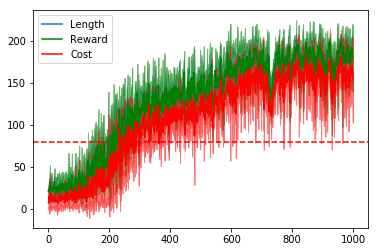

In [15]:
r = loop.achieve_reward(200, 1000, plot_every = 30)

### Training safe

In [8]:
R_thresh = 150
epochs = 500

env = make_safe_env('CartPole-v0-left-half')
env.threshold = 80
sess = create_modest_session()
agent = ConstrainedProximalPolicyOptimization(
    env, sess, steps = 5, lr_policy = 1e-3, lr_value = 1e-3)
loop = ConstrainedEpisodicTrainLoop(env, agent, episodes_to_collect=15)
sess.run(tf.global_variables_initializer())

In [9]:
agent.track_metrics([tf.linalg.norm(agent.t_delta_proj_len, name = 'proj_step'), agent.t_R, agent.t_R_clipped, tf.identity(50 * agent.t_RtoC, name = 'cos_sc')])

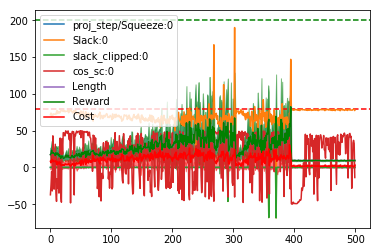

In [10]:
# RL algos can diverge after finding a solution
# https://www.reddit.com/r/MachineLearning/comments/8pcykb/d_actor_critic_ddpg_diverging_after_finding/
# Add KL-divergence check? (now missing...)

sess.run(tf.global_variables_initializer())

# train and hope...
r = loop.achieve_reward(R_thresh=R_thresh, max_epochs=epochs, plot_every=30)

1. Now have an overflow somewhere (invalid value in less), increased eps
2. Switched to SGD (maybe adam is too agressive)?
3. Estimating constraint return properly, not nly for the first episode but the mean. Mistake in constraint estimation... The moment it goes slightly above the constraint, it plummets down.
4. Next step: monitor why it stops when _reward_ reaches the threshold and not constraint. It just resets and kills the performance... Monitor a) cos b) distance to the set c) returns d) distance projected - original

In [ ]:
test_convergence_unsafe()

Want: $(\theta_1+\Delta\theta-\theta_0)^T g_C\leq C_{\max}$ which gives $\Delta\theta^T g_C\leq C_{\max}-J_C+(\theta_0-\theta_1)^T g_C=R$. In case if $R>0$, no action required. Otherwise $\Delta\theta=g_CR/\|g_C\|^2$

1. Slow convergence. Try to increase step size if $\cos (g_R, g_C)$ is approximately $1$? Measure it and check!
2. Estimate $g_C$ over many episodes to get a more reliable constraint

In [ ]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

In [ ]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')